In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk

from pprint import pprint

import spacy

import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models

C:\Users\Wahbeh\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Read data file

In [25]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\Wahbeh\\Documents\\teamA\\scripts'

In [26]:
df = pd.read_csv ('../rawData/Sample Data -  Nov 25 2020 to January 07 2021.csv')
df

,Full Text
0,@hamcore_ First the boss metal zone schematics...
1,@sippygup its in the vaccine and 5g makes it m...
2,Him and all the others that do Not like and ha...
3,@TimRunsHisMouth Him and all the others that d...
4,@NYGovCuomo 99.97% survival rate no vaccine fo...
...,...
9953,Waiting for the train and I hear two mfs say “...
9954,I played my radical left avant garde music and...
9955,You are such a fag @MayorKeller And what the F...
9956,.@seanspicer hahahaha Trump's accomplishments?...


In [27]:
docs = np.array(df['Full Text'])
docs

array(['@hamcore_ First the boss metal zone schematics as 5g in a vaccine now hitler got stuff right??? Cmon man it’s only 10:42am',
       '@sippygup its in the vaccine and 5g makes it more powerful watch out',
       "Him and all the others that do Not like and hate DonaldTrump is just because They are part of the satanic Deep State illuminati and serves different??God, the same God that gave him the power to poisoning our food and water. That's Monsanto plus he is behind the Vaccines☠️ withVP",
       ...,
       'You are such a fag @MayorKeller And what the Fuck is that que que logo all about? What a stupid waste of time and money you are. No mask No distancing No testing No vaccine @GovMLG #scamdemic',
       ".@seanspicer hahahaha Trump's accomplishments?? The vaccine? That international companies have been working on since before Trump acknowledged there was a pandemic? #Hoax The economy? It rallied when Biden won and now when the transition started. Trump killed farmers.",
    

In [28]:
print(type(docs))
print(len(docs))
print(docs.shape)
print(range(len(docs)))

<class 'numpy.ndarray'>
9958
(9958,)
range(0, 9958)


# Pre-processing

In [29]:
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')
# get a set of stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wahbeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wahbeh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
def docs_preprocessor(docs):
    # Tokenize corpus
    tokenizer = TweetTokenizer(strip_handles=True)    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.     
        

    # Only keep tokens that contains alphanumeric characters, without symbols.
    docs = [[token for token in doc if token.isalnum()] for doc in docs]
    
    # Remove stopwords.
    docs = [[token for token in doc if token not in stopwords] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [31]:
docs = docs_preprocessor(docs)
docs[4]


['survival', 'rate', 'vaccine']

In [32]:
## In case we need to follow the same steps as we did before, then there is no need to filter out words.

In [33]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
docs_dict = Dictionary(docs)
print('Number of unique words in initital documents:', len(docs_dict))

# # Filter out words that occur less than 10 documents, or more than 40% of the documents.
# docs_dict.filter_extremes(no_below=4, no_above=0.40)
# print('Number of unique words after removing rare and common words:', len(docs_dict))

Number of unique words in initital documents: 11638


In [34]:
#bag of words representation
corpus = [docs_dict.doc2bow(doc) for doc in docs]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [35]:
print('Number of unique tokens: %d' % len(docs_dict))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 11638
Number of documents: 9958


# LDA topic model

In [36]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [38]:
# Set training parameters.
num_topics = 51
chunksize = 1250 # size of the doc looked at every pass
passes = 10 # number of passes through documents
iterations = 2
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = docs_dict[0]  # This is only to "load" the dictionary.
id2word = docs_dict.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 37.6 s


In [39]:
# Compute model Perplexity - a measure of how good the model is. lower the better`
print('\nPerplexity: ', model.log_perplexity(corpus,total_docs=9958))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=docs_dict , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.449772096279057

Coherence Score:  0.5038474600993775


# Optimizing LDA model

Method to find optimal number of topics Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

Implementation from: https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb 

In [40]:
def compute_coherence_values(id2word, dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    # Fixed LDA model parameters
    chunksize = 1250 # size of the doc looked at every pass
    passes = 10 # number of passes through documents
    iterations = 2
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("LDA model with ", num_topics, "topics")
        model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
        model_list.append(model)
        
        print("Calculating coherence score")
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
model_list, coherence_values = compute_coherence_values(id2word=id2word, dictionary=docs_dict, \
                                                        corpus=corpus, texts=docs, start=2, limit=51, step=1)

LDA model with  2 topics
Calculating coherence score
LDA model with  3 topics
Calculating coherence score
LDA model with  4 topics
Calculating coherence score
LDA model with  5 topics
Calculating coherence score
LDA model with  6 topics
Calculating coherence score
LDA model with  7 topics
Calculating coherence score
LDA model with  8 topics
Calculating coherence score
LDA model with  9 topics
Calculating coherence score
LDA model with  10 topics
Calculating coherence score
LDA model with  11 topics
Calculating coherence score
LDA model with  12 topics
Calculating coherence score
LDA model with  13 topics
Calculating coherence score
LDA model with  14 topics
Calculating coherence score
LDA model with  15 topics
Calculating coherence score
LDA model with  16 topics
Calculating coherence score
LDA model with  17 topics
Calculating coherence score
LDA model with  18 topics
Calculating coherence score
LDA model with  19 topics
Calculating coherence score
LDA model with  20 topics
Calculatin

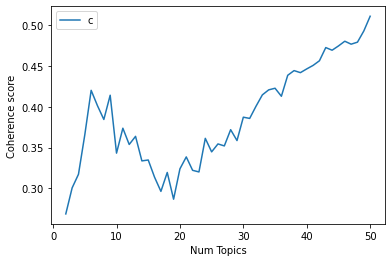

In [42]:
# Show graph
limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [43]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2687
Num Topics = 3  has Coherence Value of 0.3006
Num Topics = 4  has Coherence Value of 0.3173
Num Topics = 5  has Coherence Value of 0.3658
Num Topics = 6  has Coherence Value of 0.4202
Num Topics = 7  has Coherence Value of 0.4012
Num Topics = 8  has Coherence Value of 0.3844
Num Topics = 9  has Coherence Value of 0.4141
Num Topics = 10  has Coherence Value of 0.3432
Num Topics = 11  has Coherence Value of 0.3737
Num Topics = 12  has Coherence Value of 0.3538
Num Topics = 13  has Coherence Value of 0.3638
Num Topics = 14  has Coherence Value of 0.3337
Num Topics = 15  has Coherence Value of 0.3348
Num Topics = 16  has Coherence Value of 0.3137
Num Topics = 17  has Coherence Value of 0.2963
Num Topics = 18  has Coherence Value of 0.3195
Num Topics = 19  has Coherence Value of 0.2867
Num Topics = 20  has Coherence Value of 0.3239
Num Topics = 21  has Coherence Value of 0.3385
Num Topics = 22  has Coherence Value of 0.3221
Num Topics = 23  has 

In [50]:
type(model_list)
len(model_list)
print("Coherence score = ", coherence_values[48])
model_list[48]

Coherence score =  0.5109553844178553


In [53]:
# Select the model and print the topics
optimal_model = model_list[48]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(15,
  '0.109*"lol" + 0.096*"talking" + 0.073*"woman" + 0.055*"happens" + 0.053*"plot" + 0.039*"game" + 0.032*"however" + 0.028*"moon" + 0.023*"honestly" + 0.021*"doc"'),
 (24,
  '0.212*"kill" + 0.075*"week" + 0.055*"prevent" + 0.040*"voter" + 0.029*"community" + 0.029*"autoimmune" + 0.024*"injured" + 0.022*"watching" + 0.022*"infection" + 0.021*"thousand"'),
 (22,
  '0.121*"cdc" + 0.079*"public" + 0.068*"per" + 0.060*"spread" + 0.042*"win" + 0.038*"set" + 0.031*"device" + 0.024*"hit" + 0.022*"glad" + 0.022*"lord"'),
 (32,
  '0.086*"end" + 0.054*"damn" + 0.047*"ingredient" + 0.047*"face" + 0.046*"depopulation" + 0.044*"create" + 0.041*"decide" + 0.036*"cabal" + 0.030*"eat" + 0.029*"globalist"'),
 (48,
  '0.124*"since" + 0.117*"line" + 0.063*"called" + 0.055*"1st" + 0.055*"rushed" + 0.051*"guess" + 0.042*"due" + 0.032*"liability" + 0.025*"planning" + 0.023*"front"'),
 (26,
  '0.085*"coming" + 0.079*"agenda" + 0.078*"using" + 0.063*"created" + 0.043*"coronavirus" + 0.034*"lost" + 0.031*

# Visualize 'optimal' LDA model

In [58]:
import pyLDAvis
pyLDAvis.gensim_models
import pyLDAvis.gensim_models
import warnings
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [61]:
#pcoa:Principal Coordinate Analysis (aka Classical Multidimensional Scaling)
pyLDAvis.gensim_models.prepare(optimal_model, corpus, docs_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.337363  0.196065       1        1  14.473334
1     -0.192685 -0.070387       2        1   5.379904
45    -0.235201  0.186280       3        1   4.572355
38    -0.131552 -0.100458       4        1   3.876537
42    -0.098888 -0.051869       5        1   3.248622
20    -0.079704 -0.024862       6        1   2.934460
16    -0.044152 -0.014776       7        1   2.450823
46    -0.121643 -0.321561       8        1   2.425244
21    -0.032914 -0.024677       9        1   2.317797
35    -0.046765 -0.031578      10        1   2.311893
47    -0.050752 -0.008373      11        1   2.104413
29    -0.030559 -0.015604      12        1   2.087621
10    -0.049461  0.004438      13        1   2.055985
28    -0.013618 -0.002640      14        1   2.030920
41    -0.021567  0.010138      15        1   2.029474
43    -0.007663 -0.002180      16        1   1.914264
9     -0.001364 -0.006653      17        1   1.826555
36     0.003529  0.000565      18        1   1.806190
23     0.003972 -0.000763      19        1   1.693811
49     0.017299  0.004390      20        1   1.628577
19    -0.015900 -0.192510      21        1   1.609902
13     0.024526  0.008707      22        1   1.595571
34     0.008473  0.001279      23        1   1.592960
2      0.015204  0.001851      24        1   1.573805
37     0.023681  0.007346      25        1   1.526544
5      0.024973  0.009358      26        1   1.524390
3      0.026637  0.009199      27        1   1.524342
39     0.022088  0.006003      28        1   1.501504
11     0.027991  0.008353      29        1   1.485340
8      0.022773  0.007568      30        1   1.482493
31     0.014266  0.018292      31        1   1.477765
25     0.026407  0.003982      32        1   1.443638
40     0.034999  0.012859      33        1   1.375515
17     0.046124  0.015674      34        1   1.284961
30     0.053028  0.017300      35        1   1.233170
6      0.052408  0.017234      36        1   1.224721
44     0.059134  0.019099      37        1   1.117419
7      0.057981  0.018650      38        1   1.071155
18     0.062811  0.019993      39        1   1.066859
0      0.067122  0.021664      40        1   1.063570
33     0.063022  0.020063      41        1   1.059738
14     0.054916  0.017630      42        1   1.048528
27     0.067843  0.021392      43        1   1.042409
4      0.069441  0.021778      44        1   1.020838
26     0.074560  0.022831      45        1   0.992507
48     0.077099  0.022552      46        1   0.936902
32     0.094991  0.027805      47        1   0.821466
22     0.091994  0.027185      48        1   0.819045
24     0.102826  0.029364      49        1   0.735441
15     0.119633  0.032003      50        1   0.578723, topic_info=             Term          Freq         Total Category  logprob  loglift
11        vaccine  11634.000000  11634.000000  Default  30.0000  30.0000
0              5g   2085.000000   2085.000000  Default  29.0000  29.0000
62            get   1590.000000   1590.000000  Default  28.0000  28.0000
34          state   1675.000000   1675.000000  Default  27.0000  27.0000
17           deep   1582.000000   1582.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
3171  transmitter      4.244412      5.273454  Topic50  -5.2489   4.9350
2769    malicious      3.352873      4.381914  Topic50  -5.4847   4.8844
3170       recent      2.415457      3.444499  Topic50  -5.8126   4.7972
1205       landed      2.173603      3.202644  Topic50  -5.9181   4.7645
966        invest      1.938341      2.967382  Topic50  -6.0327   4.7263

[1550 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1500     29  0.974542      10
947      40  0.984399     100
3094      5  0.913047      12
1661     33  0.914651      13
2073     29  0.954826      15
...     ...       ...    

In [62]:
# mmds:Metric Multidimensional Scaling
pyLDAvis.gensim_models.prepare(optimal_model, corpus, docs_dict, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.154063 -0.544550       1        1  14.473332
1      0.157181  0.502165       2        1   5.379770
45    -0.529037 -0.069860       3        1   4.572348
38     0.298944  0.421359       4        1   3.876616
42    -0.295679  0.418951       5        1   3.248617
20    -0.129388  0.487304       6        1   2.934462
16     0.301452 -0.378012       7        1   2.450828
46     0.449253 -0.267408       8        1   2.425158
21     0.471257 -0.068717       9        1   2.317810
35     0.414028  0.254352      10        1   2.311885
47     0.411833  0.171738      11        1   2.104432
29     0.477627  0.058189      12        1   2.087617
10    -0.445275  0.213489      13        1   2.055989
28    -0.427708 -0.204559      14        1   2.030920
41     0.073924 -0.446822      15        1   2.029442
43    -0.167723 -0.323783      16        1   1.914264
9     -0.361005 -0.310781      17        1   1.826559
36     0.045731  0.273378      18        1   1.806177
23    -0.043516  0.404282      19        1   1.693811
49     0.030811 -0.206007      20        1   1.628577
19     0.394308 -0.163220      21        1   1.610072
13    -0.158244  0.356736      22        1   1.595569
34     0.286342  0.298351      23        1   1.592960
2     -0.330153  0.292874      24        1   1.573814
37     0.049499  0.417198      25        1   1.526544
5     -0.291656  0.215895      26        1   1.524389
3     -0.420415  0.003695      27        1   1.524342
39    -0.413896  0.109350      28        1   1.501504
11     0.361232  0.045617      29        1   1.485340
8     -0.231002 -0.409273      30        1   1.482484
31     0.290794 -0.111638      31        1   1.477766
25     0.147564  0.321748      32        1   1.443647
40     0.226917  0.189486      33        1   1.375515
17    -0.350567 -0.104427      34        1   1.284953
30     0.169021 -0.331294      35        1   1.233170
6     -0.056029 -0.432762      36        1   1.224721
44    -0.265441 -0.267472      37        1   1.117419
7      0.265761 -0.243768      38        1   1.071155
18    -0.140863  0.228175      39        1   1.066859
0      0.028641 -0.306395      40        1   1.063567
33    -0.283925  0.046546      41        1   1.059738
14    -0.108674 -0.373626      42        1   1.048528
27     0.228266  0.017634      43        1   1.042409
4      0.007505  0.092798      44        1   1.020838
26     0.144293 -0.162861      45        1   0.992507
48    -0.214433 -0.152912      46        1   0.936903
32    -0.133959  0.097560      47        1   0.821466
22     0.105792  0.041277      48        1   0.819044
24    -0.151908 -0.058213      49        1   0.735441
15    -0.041538 -0.041790      50        1   0.578723, topic_info=             Term          Freq         Total Category  logprob  loglift
11        vaccine  11634.000000  11634.000000  Default  30.0000  30.0000
0              5g   2085.000000   2085.000000  Default  29.0000  29.0000
62            get   1590.000000   1590.000000  Default  28.0000  28.0000
34          state   1676.000000   1676.000000  Default  27.0000  27.0000
17           deep   1582.000000   1582.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
3171  transmitter      4.244412      5.273455  Topic50  -5.2489   4.9350
2769    malicious      3.352873      4.381915  Topic50  -5.4847   4.8844
3170       recent      2.415457      3.444500  Topic50  -5.8126   4.7972
1205       landed      2.173603      3.202646  Topic50  -5.9181   4.7645
966        invest      1.938341      2.967383  Topic50  -6.0327   4.7263

[1550 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1500     29  0.974542      10
947      40  0.984402     100
3094      5  0.913048      12
1661     33  0.914651      13
2073     29  0.954826      15
...     ...       ...    

In [63]:
#tsne:t-distributed Stochastic Neighbor Embedding
pyLDAvis.gensim_models.prepare(optimal_model, corpus, docs_dict, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
12     270.958282  242.780914       1        1  14.473597
1     -680.701599  402.464325       2        1   5.379698
45    -339.636871   -3.460414       3        1   4.572116
38    -287.936157 -150.645126       4        1   3.876637
42    -223.737259 -265.608734       5        1   3.248619
20      64.950294 -337.809296       6        1   2.934461
16     149.075195  258.390900       7        1   2.450826
46    -291.639771  120.963608       8        1   2.424917
21     320.316833  -28.517231       9        1   2.317805
35     291.811920 -152.315079      10        1   2.311903
47    -102.333069  254.131302      11        1   2.104439
29    -183.949890  186.263931      12        1   2.087621
10       1.065677  327.445679      13        1   2.055989
28     109.576302 -180.694824      14        1   2.030920
41     -74.641319 -305.748718      15        1   2.029441
43     -46.740810 -220.019302      16        1   1.914263
9      262.653076   74.174484      17        1   1.826558
36      38.993706  228.115356      18        1   1.806194
23     187.728271  131.887650      19        1   1.693811
49     100.776733  164.778229      20        1   1.628577
19    -239.484482   74.315758      21        1   1.610276
13     164.984039 -249.278625      22        1   1.595570
34     221.681290  -29.225327      23        1   1.592960
2      195.118103 -141.547211      24        1   1.573811
37      72.719337   95.781990      25        1   1.526544
5      -28.751133  177.440491      26        1   1.524389
3     -226.836121  -59.637829      27        1   1.524342
39    -148.198624 -188.919617      28        1   1.501504
11     -99.317482   19.867552      29        1   1.485340
8     -149.989426   76.108963      30        1   1.482489
31     -89.271248  125.285423      31        1   1.477765
25      39.763596 -227.677750      32        1   1.443639
40     -75.856583 -142.913345      33        1   1.375515
17     144.325150  -13.160837      34        1   1.284968
30    -159.257278  -15.673578      35        1   1.233170
6      137.788803  -87.678467      36        1   1.224721
44       6.867877 -146.203796      37        1   1.117419
7        1.750013  106.679131      38        1   1.071155
18     139.487991   58.211777      39        1   1.066859
0       76.048950   21.549555      40        1   1.063571
33      67.137566 -112.945648      41        1   1.059738
14    -141.626785  -98.970734      42        1   1.048528
27      79.423653  -43.914883      43        1   1.042410
4      -86.226791  -51.375149      44        1   1.020838
26     -33.454407  -87.024460      45        1   0.992507
48     -44.055805   52.511707      46        1   0.936903
32     -33.032280  -15.238327      47        1   0.821466
22      15.614791   38.038414      48        1   0.819046
24      19.527269  -66.093307      49        1   0.735441
15      20.735121  -15.729597      50        1   0.578723, topic_info=             Term          Freq         Total Category  logprob  loglift
11        vaccine  11634.000000  11634.000000  Default  30.0000  30.0000
0              5g   2085.000000   2085.000000  Default  29.0000  29.0000
62            get   1590.000000   1590.000000  Default  28.0000  28.0000
34          state   1676.000000   1676.000000  Default  27.0000  27.0000
17           deep   1582.000000   1582.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
3171  transmitter      4.244412      5.273456  Topic50  -5.2489   4.9350
2769    malicious      3.352873      4.381916  Topic50  -5.4847   4.8844
3170       recent      2.415457      3.444501  Topic50  -5.8126   4.7972
1205       landed      2.173603      3.202647  Topic50  -5.9181   4.7645
966        invest      1.938341      2.967384  Topic50  -6.0327   4.7263

[1550 rows x 6 columns], token_table=      Topic      Freq    Te